In [ ]:
# ..... expressolog score across species - chicken and turtle ..... #

In [1]:
# specificity calculation
calc_spec <- function (res, np, nL){    
  
  ranks = 1:nL
  mini = sum(ranks[1:np])
  range = np*(nL - np)
  
  temp1 = t(apply(res, 1, function(x) rank(x, ties.method = "average")))      
  spec1 <- (temp1 - mini)/range   
  temp2 = t(apply(t(res), 1, function(x) rank(x, ties.method = "average")))      
  spec2 <- (temp2 - mini)/range
  spec = 0.5*(spec1 + t(spec2))
  
  return(diag(spec))  # return full matrix
}  

In [31]:
# get orthologs
om = read.delim('~/septation/turtle/turtle_chicken_orthologs_biomart.txt', sep = '\t')
om <- om[which(om[,1]!='' & om[,2]!='' & !is.na(om[,5]) & om[,5]==1 & om[,4]=='ortholog_one2one'),]
dim(om)
om[1,]

[1] 11275     5

Gene.name Chicken.gene.name Last.common.ancestor.with.Chicken
10 ND2       ND2               Archelosauria                    
   Chicken.homology.type Chicken.orthology.confidence..0.low..1.high.
10 ortholog_one2one      1

In [21]:
# get orthologs
# om = read.delim('~/septation/lizard/lizard_chicken_orthologs_eggNOG.txt', sep = '\t')
om = read.delim('~/septation/lizard/lizard_turtle_orthologs_eggNOG.txt', sep = '\t')

om <- om[,c('lizard_gene', 'ortholog_name', 'orth_type')]
om <- om[which(om$ortholog_name!='' & om$lizard_gene!='' & !is.na(om$ortholog_name) & !is.na(om$lizard_gene) & om[,3]=='one2one'),]
dim(om)
om[1,]

[1] 27963     3

lizard_gene ortholog_name orth_type
1 ARHGEF10    ARHGEF10      one2one

In [32]:
# load pseudobulk data
sp1 = 'chicken'
sp2 = 'turtle'

cstages = c('stage23', 'stage28', 'stage32')
tstages = c('stage14', 'stage17', 'stage21')
# cstages = c('stage9', 'stage13', 'stage16')


combos = rbind(rep(cstages, each = 3), rep(tstages, 3))
combos

[,1]    [,2]    [,3]    [,4]    [,5]    [,6]    [,7]    [,8]    [,9]   
[1,] stage23 stage23 stage23 stage28 stage28 stage28 stage32 stage32 stage32
[2,] stage14 stage17 stage21 stage14 stage17 stage21 stage14 stage17 stage21

In [39]:
pb = txtProgressBar(min = 0, max = 9, initial = 0)

for(ii in 1:dim(combos)[2]){
    path1 = combos[1,ii]
    path2 = combos[2,ii]
    
    load(paste0('~/septation/', sp1, '/', path1, '_integrated_pseudobulk_expression_matrix.Rdata'))
    scbulk1 = m1
    load(paste0('~/septation/', sp2, '/', path2, '_integrated_pseudobulk_expression_matrix.Rdata'))
    scbulk2 = m1
    
    # load(paste0(sp2, '/', path2, '_pseudobulk_expression_matrices.Rdata'))
    # scbulk2 = scbulk1
    # load(paste0(sp1, '/', path1, '_pseudobulk_expression_matrices.Rdata'))
    
    
    
    # rename chicken data gene names
    genes1 = rownames(scbulk1)[match(om[,2], rownames(scbulk1))]
    genes2 = rownames(scbulk2)[match(om[,1], rownames(scbulk2))]
    common_id = which(!is.na(genes1) & !is.na(genes2))
    
    
    mat1 = scbulk1[genes1[common_id],]
    mat2 = scbulk2[genes2[common_id],]
    rownames(mat2) <- rownames(mat1)
    colnames(mat2) <- colnames(mat1)
    print(dim(mat2)[1])
    
    
    # remove low-expr genes
    common_genes = intersect(rownames(mat1)[rowSums(mat1)>5], rownames(mat2)[rowSums(mat2)>5])
    mat1 <- mat1[common_genes,]
    mat2 <- mat2[common_genes,]
    
    # keep common cell types
    # common_types = intersect(colnames(scbulk1), colnames(scbulk2))
    # mat1 <- mat1[,common_types]
    # mat2 <- mat2[,common_types]
    
    
    # correlate across all subclasses
    options(warn = -1)
    fullcorr = cor(t(mat1), t(mat2), method = 'pearson')
    
    # specificity scores
    fullcorrspec = calc_spec(fullcorr, 1, dim(fullcorr)[1])
    
    # save
    newdf = data.frame(gene = common_genes, expressolog = fullcorrspec)
    write.table(newdf, file = paste0(sp1, '_', path1, '_', sp2, '_', path2, '_expressolog.csv'), sep = ',',
                                    row.names = F, col.names = T, quote = F)

    setTxtProgressBar(pb, ii)
}

[1] 10481
=========[1] 10481
=========[1] 10481
=========[1] 10481
=========[1] 10481
========[1] 10481
=========[1] 10481
=========[1] 10481
=========[1] 10481

gene    expressolog
PLEKHB1 PLEKHB1 0.09735551 
RAB6A   RAB6A   0.98075283 
MRPL48  MRPL48  0.39853913 
PAAF1   PAAF1   0.32357646 
DNAJB13 DNAJB13 0.06349968 
C2CD3   C2CD3   0.33269354

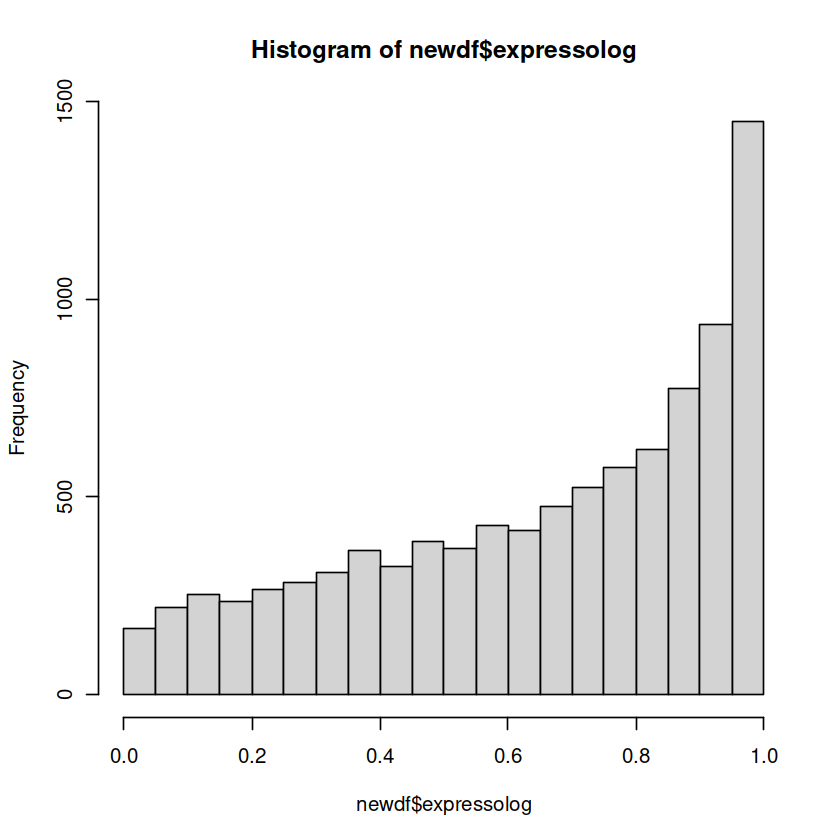

In [40]:
head(newdf)
hist(newdf$expressolog)

In [11]:
# plot distributions of scores
library(ggplot2)
library(ggridges)
library(corrplot)

corrplot 0.92 loaded



In [41]:
newdf = c()
corrmat = matrix(NA, nrow = 3, ncol = 3)
for(ii in 1:dim(combos)[2]){
    df1 = read.delim(paste0(sp1, '_', combos[1,ii], '_', sp2, '_', combos[2,ii], '_expressolog.csv'), sep = ',')
    df1$stage = paste0(combos[1,ii], '_', combos[2,ii])
    corrmat[match(combos[1,ii], cstages), match(combos[2,ii], tstages)] = mean(df1$expressolog, na.rm = T)    
    newdf = rbind(newdf, df1)
}
newdf[1,]
rownames(corrmat) = cstages
colnames(corrmat) = tstages
corrmat

gene    expressolog stage          
1 PLEKHB1 0.2566007   stage23_stage14

stage14   stage17   stage21  
stage23 0.6077314 0.6251527 0.6100700
stage28 0.6504385 0.6761833 0.6519103
stage32 0.6428593 0.6625077 0.6521825

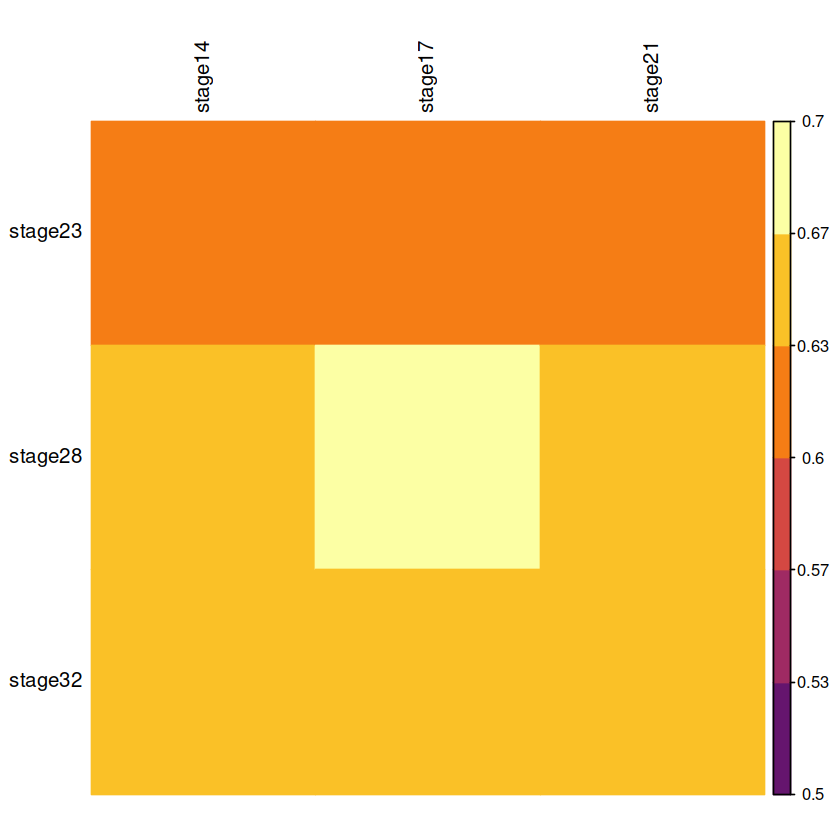

In [43]:
# ggplot(newdf, aes(x = stage, y = expressolog)) + geom_boxplot()
library(viridis)
my_palette = viridis::inferno(8)
# png('aa-human-mouse.png', width = 5, height = 5, res = 300, units = 'in')
# pdf('aa-chicken-turtle-3x3.pdf', width = 5, height = 5)
corrplot(corrmat, method = 'color', is.corr = F, col = my_palette[3:8], col.lim = c(0.5,0.7),
         tl.col = 'black', na.label = ' ', na.label.col = 'white')
# dev.off()

In [26]:
library(ggplot2)

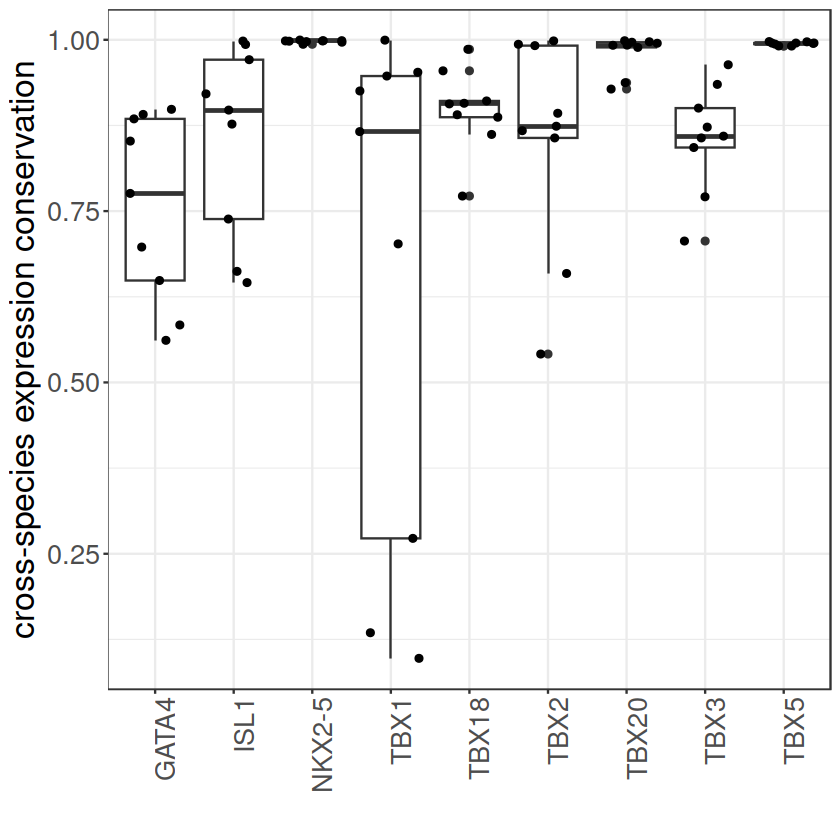

In [32]:
geens = c('NKX2-5', 'GATA4', 'NPPA', 'TBX1', 'TBX2', 'TBX3', 'TBX5', 'TBX18', 'TBX20', 'ISL1')
temp = newdf[newdf$gene %in% geens,]
# png('AAAAA_Mantri_MN.png', width = 7, height = 7, res = 300, units = 'in')
ggplot(temp, aes(x = gene, y = expressolog)) + geom_boxplot() + geom_jitter() + theme_bw() +
theme(text = element_text(size=20), axis.text.x = element_text(angle=90, hjust=1)) + xlab('') +
ylab('cross-species expression conservation')
# dev.off()

In [14]:
source('gene_set_enrichment.R')
ginfo = read.delim('/data/CoCoCoNet/geneInfo/human_info.csv', sep = ',')

In [24]:
divs = newdf$gene[newdf$expressolog<0.5 & newdf$stage=='stage28_stage17']
divs = ginfo$NetworkIDs[match(divs, ginfo$GeneSymbol)]
divs = divs[!is.na(divs)]

# custom functional gene sets is sig associated with divergent genes
gse = gene_set_enrichment(divs, 'human')
head(gse)
gse$description[gse$adj_pvals<1e-3]

GO_term    description                                  N_sample
GO:0019637 GO:0019637 organophosphate metabolic process            189     
GO:0019752 GO:0019752 carboxylic acid metabolic process            171     
GO:1901137 GO:1901137 carbohydrate derivative biosynthetic process 127     
GO:1990234 GO:1990234 transferase complex                          154     
GO:0042578 GO:0042578 phosphoric ester hydrolase activity           89     
GO:0016301 GO:0016301 kinase activity                              155     
           N_univ pvals        adj_pvals    sig 
GO:0019637 982    1.081054e-15 9.718677e-12 TRUE
GO:0019752 962    2.854205e-11 1.282965e-07 TRUE
GO:1901137 657    4.632128e-11 1.388094e-07 TRUE
GO:1990234 858    1.383569e-10 3.109572e-07 TRUE
GO:0042578 418    2.664607e-10 4.080239e-07 TRUE
GO:0016301 873    2.723185e-10 4.080239e-07 TRUE

[1] "organophosphate metabolic process"                            
 [2] "carboxylic acid metabolic process"                            
 [3] "carbohydrate derivative biosynthetic process"                 
 [4] "transferase complex"                                          
 [5] "phosphoric ester hydrolase activity"                          
 [6] "kinase activity"                                              
 [7] "hydrolase activity; acting on ester bonds"                    
 [8] "organophosphate biosynthetic process"                         
 [9] "organic acid catabolic process"                               
[10] "carboxylic acid catabolic process"                            
[11] "phospholipid metabolic process"                               
[12] "cellular amino acid metabolic process"                        
[13] "phosphatidylinositol biosynthetic process"                    
[14] "small molecule catabolic process"                             
[15] "ncRNA metabolic process"                                      
[16] "metal ion transport"                                          
[17] "phosphotransferase activity; alcohol group as acceptor"       
[18] "lipid biosynthetic process"                                   
[19] "phospholipid biosynthetic process"                            
[20] "ubiquitin ligase complex"                                     
[21] "glycerophospholipid metabolic process"                        
[22] "nucleobase-containing small molecule metabolic process"       
[23] "Golgi membrane"                                               
[24] "divalent metal ion transport"                                 
[25] "divalent inorganic cation transport"                          
[26] "organophosphate catabolic process"                            
[27] "glycerolipid metabolic process"                               
[28] "protein modification by small protein conjugation"            
[29] "tRNA metabolic process"                                       
[30] "phosphatidylinositol metabolic process"                       
[31] "cation transport"                                             
[32] "glycerophospholipid biosynthetic process"                     
[33] "alpha-amino acid metabolic process"                           
[34] "response to extracellular stimulus"                           
[35] "coenzyme binding"                                             
[36] "glycerolipid biosynthetic process"                            
[37] "response to nutrient levels"                                  
[38] "calcium ion transport"                                        
[39] "ribosome biogenesis"                                          
[40] "phosphatidylinositol binding"                                 
[41] "monocarboxylic acid catabolic process"                        
[42] "catalytic activity; acting on RNA"                            
[43] "ncRNA processing"                                             
[44] "DNA metabolic process"                                        
[45] "small molecule biosynthetic process"                          
[46] "early endosome"                                               
[47] "metal ion transmembrane transporter activity"                 
[48] "somatodendritic compartment"                                  
[49] "inorganic ion transmembrane transport"                        
[50] "glycoprotein biosynthetic process"                            
[51] "ion transmembrane transporter activity"                       
[52] "nucleoside phosphate metabolic process"                       
[53] "GPI anchor biosynthetic process"                              
[54] "cellular protein catabolic process"                           
[55] "nucleotide metabolic process"                                 
[56] "dephosphorylation"                                            
[57] "isomerase activity"                                           
[58] "calcium ion transmembrane transport"                          